# Random Forest

## Introduction

Random Forest is a powerful ensemble learning method that builds upon the concept of decision trees. It creates multiple decision trees during training and outputs the mode of the classes (classification) or mean prediction (regression) of the individual trees.

The key principles of Random Forest include:

1. **Bootstrap Aggregating (Bagging)**: Each tree is trained on a random subset of the data, with replacement.
2. **Feature Randomness**: At each split in a tree, only a random subset of features is considered.
3. **Ensemble Learning**: Combines predictions from multiple trees to reduce overfitting and improve accuracy.

Advantages of Random Forest:
- Reduces overfitting compared to single decision trees
- Handles high-dimensional data effectively
- Provides feature importance measures
- Works well for both classification and regression tasks
- Robust to outliers and non-linear data

In this notebook, we'll implement Random Forest for both classification and regression tasks, exploring its performance, tuning, and interpretation.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, 
    classification_report, roc_curve, roc_auc_score, mean_squared_error, r2_score
)
from sklearn.inspection import permutation_importance
import joblib
import warnings

# Set up visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')
sns.set_palette('Set2')

# Set random seed for reproducibility
np.random.seed(42)

## PART I: Random Forest Classification

### 1. Data Loading and Exploration - Breast Cancer Dataset

In [3]:
# Load the Breast Cancer dataset
cancer = load_breast_cancer()
X_cls = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_cls = cancer.target

# Display information about the dataset
print(f"Dataset shape: {X_cls.shape}")
print(f"Feature names sample: {cancer.feature_names[:5]}...")
print(f"Target classes: {cancer.target_names}")
print(f"Class distribution: {np.bincount(y_cls)}")
print(f"Class proportions: {np.bincount(y_cls) / len(y_cls)}")

Dataset shape: (569, 30)
Feature names sample: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness']...
Target classes: ['malignant' 'benign']
Class distribution: [212 357]
Class proportions: [0.37258348 0.62741652]


In [4]:
# Create a DataFrame that includes the target variable
cancer_df = X_cls.copy()
cancer_df['diagnosis'] = [cancer.target_names[i] for i in y_cls]

# Display the first few rows of the dataset
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,malignant
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,malignant
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,malignant
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,malignant
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,malignant


In [5]:
# Descriptive statistics
cancer_df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


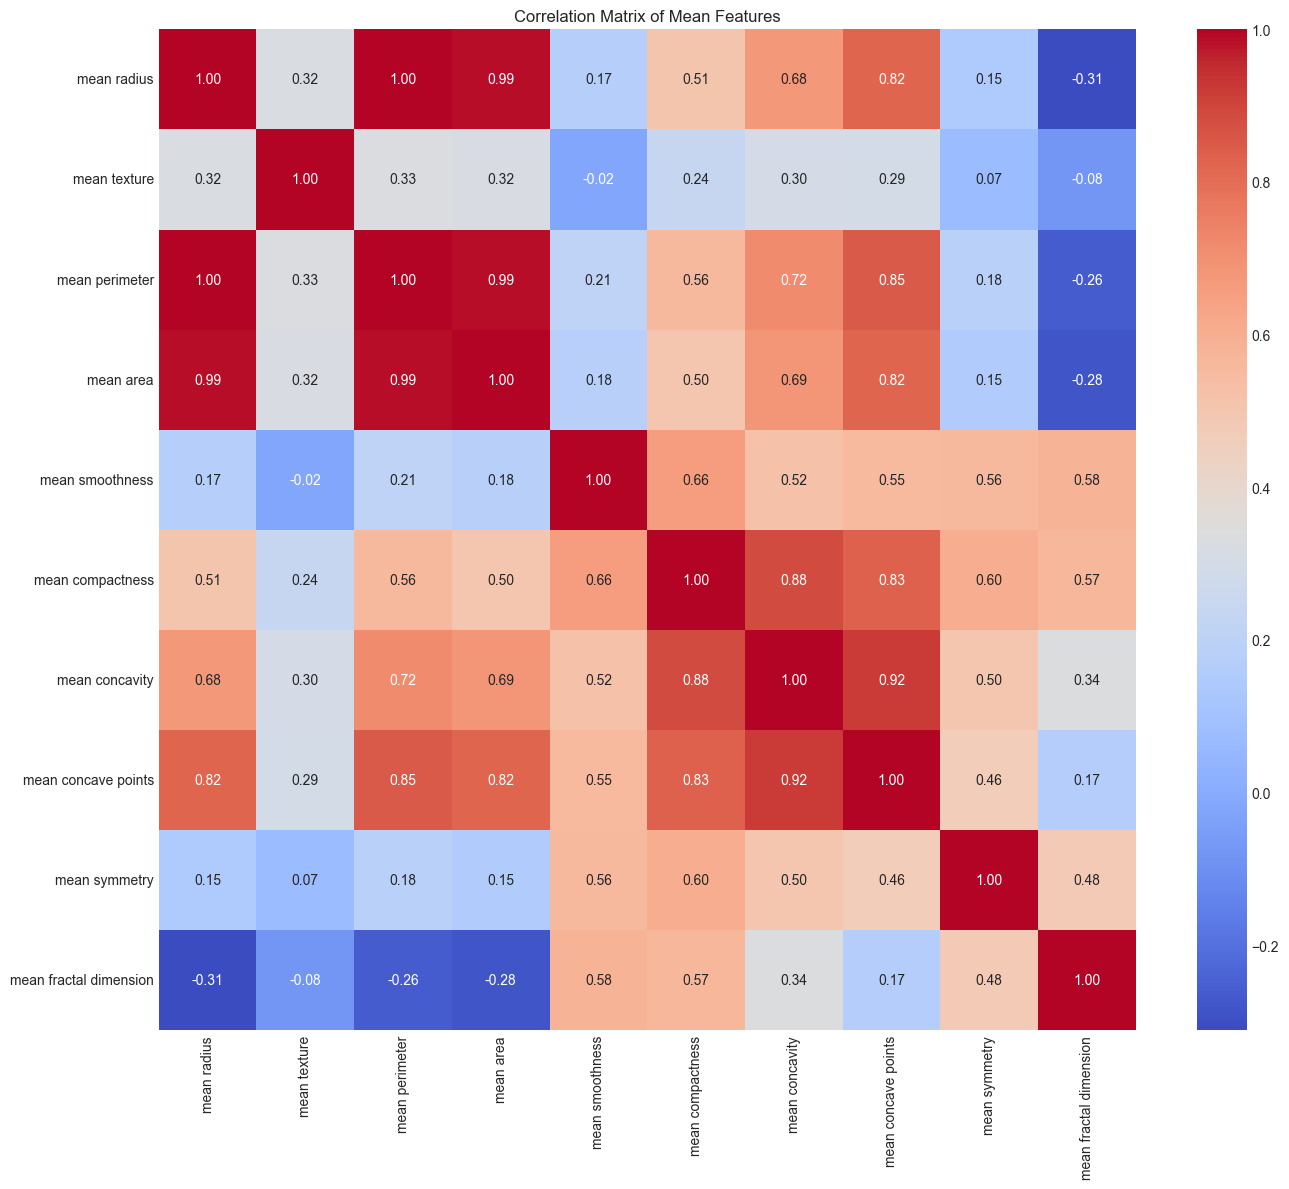

In [6]:
# Correlation heatmap for selected features
plt.figure(figsize=(14, 12))
mean_features = [col for col in X_cls.columns if 'mean' in col]
correlation = X_cls[mean_features].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Mean Features')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

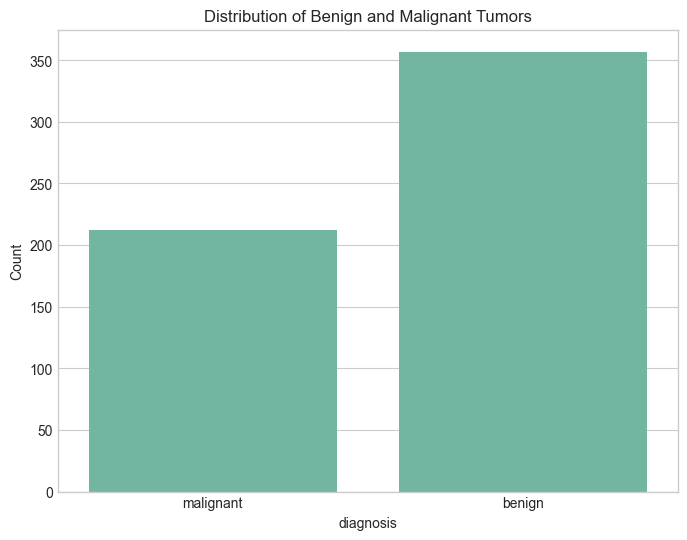

In [7]:
# Visualize the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='diagnosis', data=cancer_df)
plt.title('Distribution of Benign and Malignant Tumors')
plt.ylabel('Count')
plt.show()

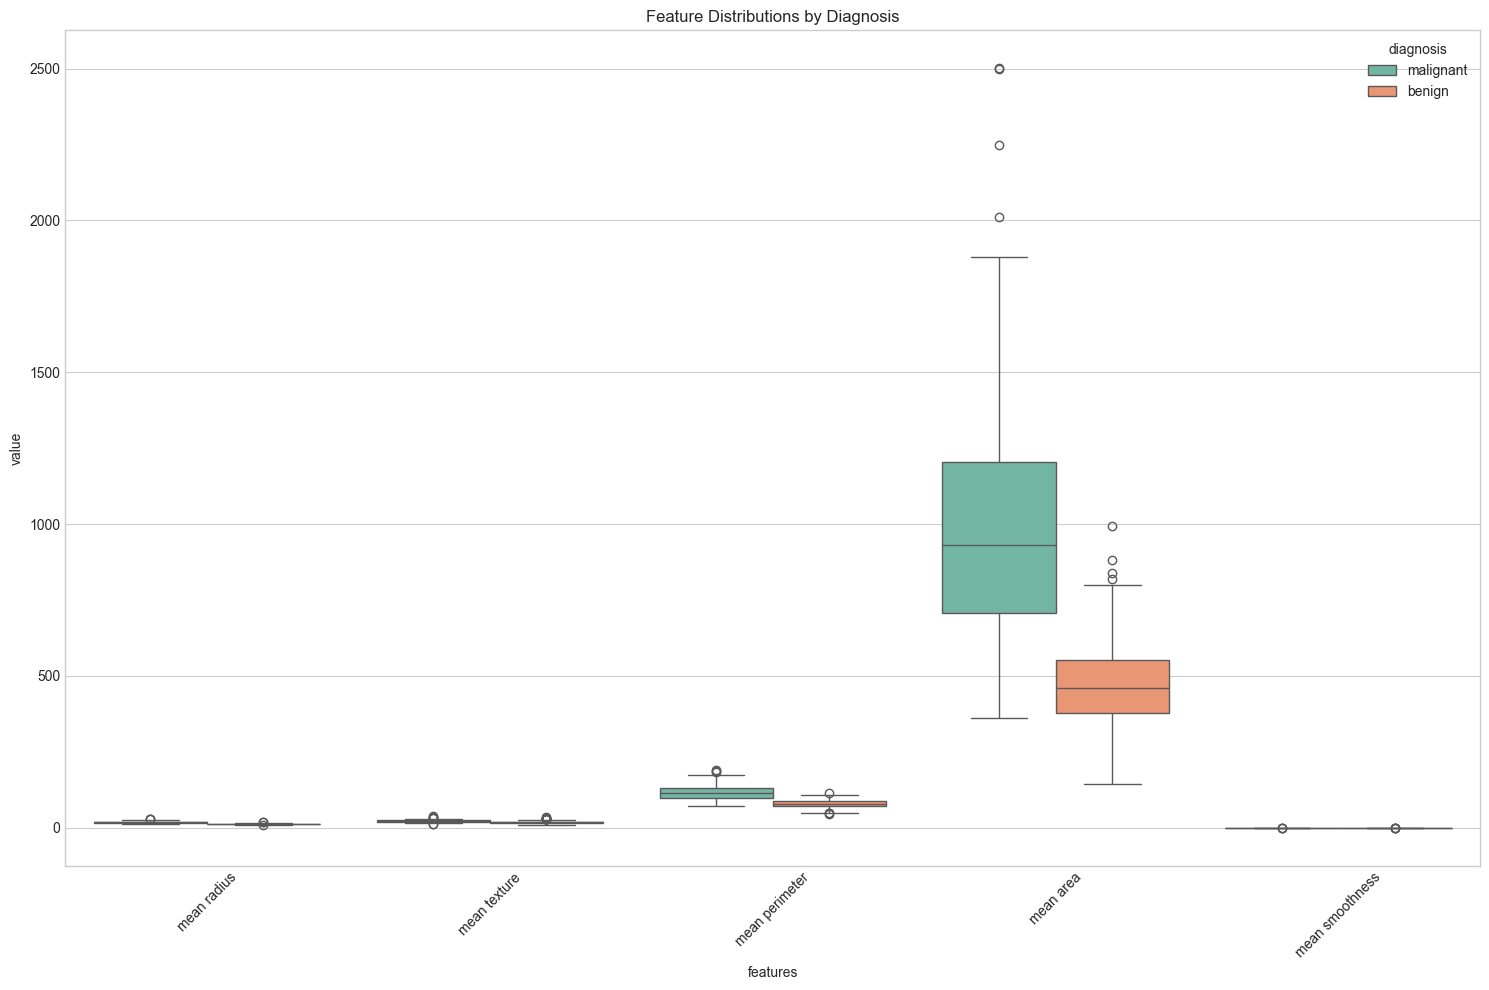

In [8]:
# Boxplots for selected features by diagnosis
plt.figure(figsize=(15, 10))
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness']
melted_df = pd.melt(cancer_df[selected_features + ['diagnosis']], id_vars='diagnosis', var_name='features', value_name='value')
sns.boxplot(x='features', y='value', hue='diagnosis', data=melted_df)
plt.title('Feature Distributions by Diagnosis')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 2. Data Preprocessing

In [9]:
# Split the data into training and testing sets
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

print(f"Training set shape: {X_train_cls.shape}")
print(f"Testing set shape: {X_test_cls.shape}")
print(f"Training class distribution: {np.bincount(y_train_cls)}")
print(f"Testing class distribution: {np.bincount(y_test_cls)}")

Training set shape: (455, 30)
Testing set shape: (114, 30)
Training class distribution: [170 285]
Testing class distribution: [42 72]


In [10]:
# Feature scaling
# Note: Random Forest doesn't strictly require feature scaling, but it can help with some cases
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

# Convert back to DataFrames
X_train_cls_scaled_df = pd.DataFrame(X_train_cls_scaled, columns=X_cls.columns)
X_test_cls_scaled_df = pd.DataFrame(X_test_cls_scaled, columns=X_cls.columns)

print("First 5 rows of scaled training data:")
X_train_cls_scaled_df.head()

First 5 rows of scaled training data:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-1.072001,-0.658425,-1.088080,-0.939274,-0.135940,-1.008718,-0.968359,-1.102032,0.281062,-0.113231,...,-1.034094,-0.623497,-1.070773,-0.876534,-0.169982,-1.038836,-1.078995,-1.350527,-0.352658,-0.541380
1,1.748743,0.066502,1.751157,1.745559,1.274468,0.842288,1.519852,1.994664,-0.293045,-0.320180,...,1.228342,-0.092833,1.187467,1.104386,1.517001,0.249655,1.178594,1.549916,0.191078,-0.173739
2,-0.974734,-0.931124,-0.997709,-0.867589,-0.613515,-1.138154,-1.092292,-1.243358,0.434395,-0.429247,...,-0.973231,-1.036772,-1.008044,-0.834168,-1.097823,-1.167260,-1.282241,-1.707442,-0.307734,-1.213033
3,-0.145103,-1.215186,-0.123013,-0.253192,0.664482,0.286762,-0.129729,-0.098605,0.555635,0.029395,...,-0.251266,-1.369643,-0.166633,-0.330292,0.234006,0.096874,-0.087521,-0.344838,0.242198,-0.118266
4,-0.771617,-0.081211,-0.803700,-0.732927,-0.672282,-1.006099,-0.798502,-0.684484,0.737495,-0.457213,...,-0.801135,0.079230,-0.824381,-0.741830,-0.911367,-0.984612,-0.933190,-0.777604,0.555118,-0.761639


### 3. Building a Basic Random Forest Classifier

In [11]:
# Initialize and train a basic random forest classifier
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train_cls, y_train_cls)  # Use unscaled features for Random Forest

# Make predictions
y_train_pred_cls = rf_cls.predict(X_train_cls)
y_test_pred_cls = rf_cls.predict(X_test_cls)

# Get probability predictions for ROC curve
y_train_proba_cls = rf_cls.predict_proba(X_train_cls)[:, 1]
y_test_proba_cls = rf_cls.predict_proba(X_test_cls)[:, 1]

# Evaluate the model
train_accuracy_cls = accuracy_score(y_train_cls, y_train_pred_cls)
test_accuracy_cls = accuracy_score(y_test_cls, y_test_pred_cls)
train_precision_cls = precision_score(y_train_cls, y_train_pred_cls)
test_precision_cls = precision_score(y_test_cls, y_test_pred_cls)
train_recall_cls = recall_score(y_train_cls, y_train_pred_cls)
test_recall_cls = recall_score(y_test_cls, y_test_pred_cls)
train_f1_cls = f1_score(y_train_cls, y_train_pred_cls)
test_f1_cls = f1_score(y_test_cls, y_test_pred_cls)
train_roc_auc_cls = roc_auc_score(y_train_cls, y_train_proba_cls)
test_roc_auc_cls = roc_auc_score(y_test_cls, y_test_proba_cls)

print(f"Training Accuracy: {train_accuracy_cls:.4f}")
print(f"Testing Accuracy: {test_accuracy_cls:.4f}")
print(f"Training Precision: {train_precision_cls:.4f}")
print(f"Testing Precision: {test_precision_cls:.4f}")
print(f"Training Recall: {train_recall_cls:.4f}")
print(f"Testing Recall: {test_recall_cls:.4f}")
print(f"Training F1 Score: {train_f1_cls:.4f}")
print(f"Testing F1 Score: {test_f1_cls:.4f}")
print(f"Training ROC AUC: {train_roc_auc_cls:.4f}")
print(f"Testing ROC AUC: {test_roc_auc_cls:.4f}")

Training Accuracy: 1.0000
Testing Accuracy: 0.9561
Training Precision: 1.0000
Testing Precision: 0.9589
Training Recall: 1.0000
Testing Recall: 0.9722
Training F1 Score: 1.0000
Testing F1 Score: 0.9655
Training ROC AUC: 1.0000
Testing ROC AUC: 0.9937


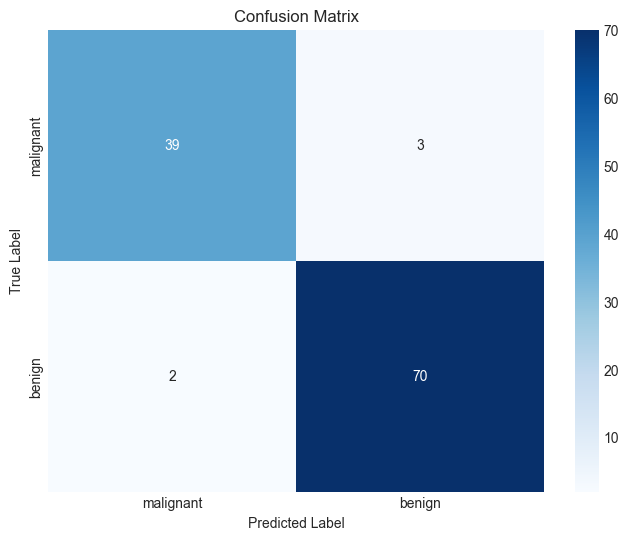

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In [12]:
# Confusion matrix
cm_cls = confusion_matrix(y_test_cls, y_test_pred_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cls, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test_cls, y_test_pred_cls, target_names=cancer.target_names))

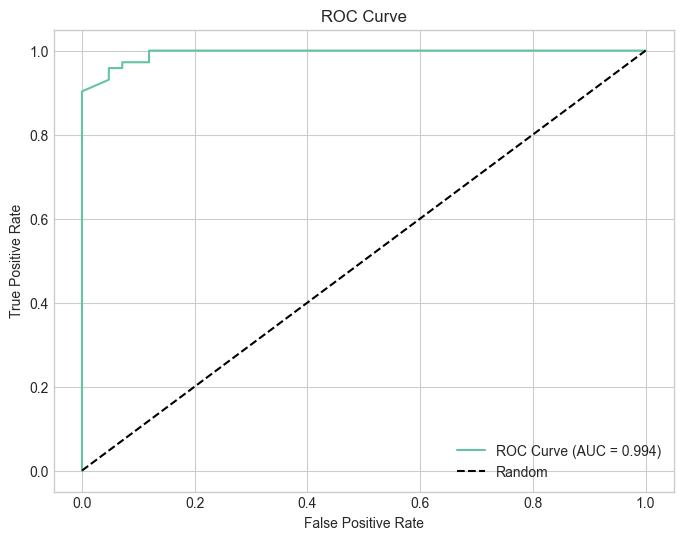

In [13]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_cls, y_test_proba_cls)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {test_roc_auc_cls:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Check for overfitting
print(f"Difference between training and testing accuracy: {train_accuracy_cls - test_accuracy_cls:.4f}")
if train_accuracy_cls - test_accuracy_cls > 0.05:
    print("The model may be overfitting.")
else:
    print("The model seems well-balanced.")

Difference between training and testing accuracy: 0.0439
The model seems well-balanced.


### 4. Feature Importance

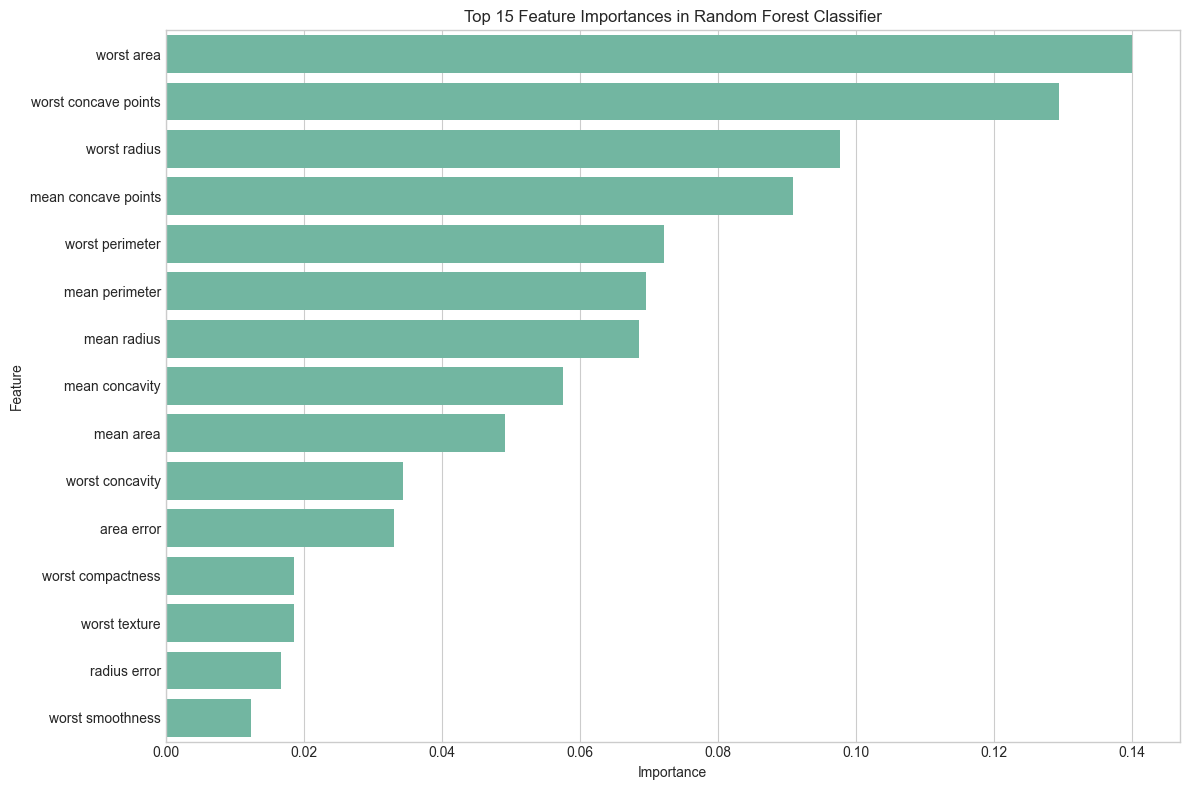

In [15]:
# Feature importance from the model
feature_importance_cls = pd.DataFrame({
    'Feature': X_cls.columns,
    'Importance': rf_cls.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_cls.head(15))
plt.title('Top 15 Feature Importances in Random Forest Classifier')
plt.tight_layout()
plt.show()

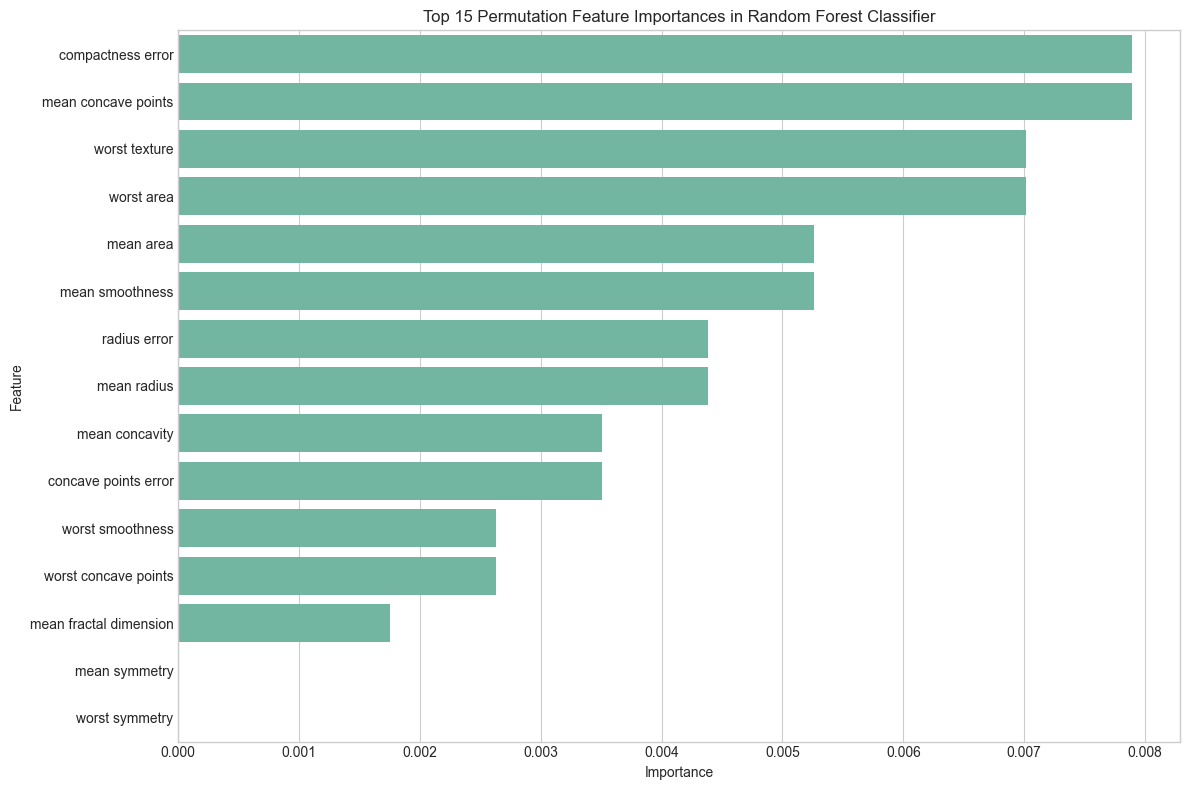

In [16]:
# Permutation importance (more reliable but slower)
perm_importance = permutation_importance(rf_cls, X_test_cls, y_test_cls, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    'Feature': X_cls.columns,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=perm_importance_df.head(15))
plt.title('Top 15 Permutation Feature Importances in Random Forest Classifier')
plt.tight_layout()
plt.show()

### 5. Hyperparameter Tuning

In [17]:
# Define hyperparameters grid
param_grid_cls = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# GridSearchCV
# Note: We'll use a smaller parameter grid to reduce computation time
reduced_param_grid_cls = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

grid_search_cls = GridSearchCV(RandomForestClassifier(random_state=42), reduced_param_grid_cls, 
                           cv=5, scoring='accuracy')
grid_search_cls.fit(X_train_cls, y_train_cls)

# Best parameters and score
print(f"Best parameters: {grid_search_cls.best_params_}")
print(f"Best cross-validation score: {grid_search_cls.best_score_:.4f}")

# Best model
best_rf_cls = grid_search_cls.best_estimator_

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Best cross-validation score: 0.9604


In [18]:
# Evaluate the best model
y_train_pred_best_cls = best_rf_cls.predict(X_train_cls)
y_test_pred_best_cls = best_rf_cls.predict(X_test_cls)
y_train_proba_best_cls = best_rf_cls.predict_proba(X_train_cls)[:, 1]
y_test_proba_best_cls = best_rf_cls.predict_proba(X_test_cls)[:, 1]

best_train_accuracy_cls = accuracy_score(y_train_cls, y_train_pred_best_cls)
best_test_accuracy_cls = accuracy_score(y_test_cls, y_test_pred_best_cls)
best_train_roc_auc_cls = roc_auc_score(y_train_cls, y_train_proba_best_cls)
best_test_roc_auc_cls = roc_auc_score(y_test_cls, y_test_proba_best_cls)

print(f"Best Model Training Accuracy: {best_train_accuracy_cls:.4f}")
print(f"Best Model Testing Accuracy: {best_test_accuracy_cls:.4f}")
print(f"Best Model Training ROC AUC: {best_train_roc_auc_cls:.4f}")
print(f"Best Model Testing ROC AUC: {best_test_roc_auc_cls:.4f}")

Best Model Training Accuracy: 0.9934
Best Model Testing Accuracy: 0.9474
Best Model Training ROC AUC: 0.9998
Best Model Testing ROC AUC: 0.9944


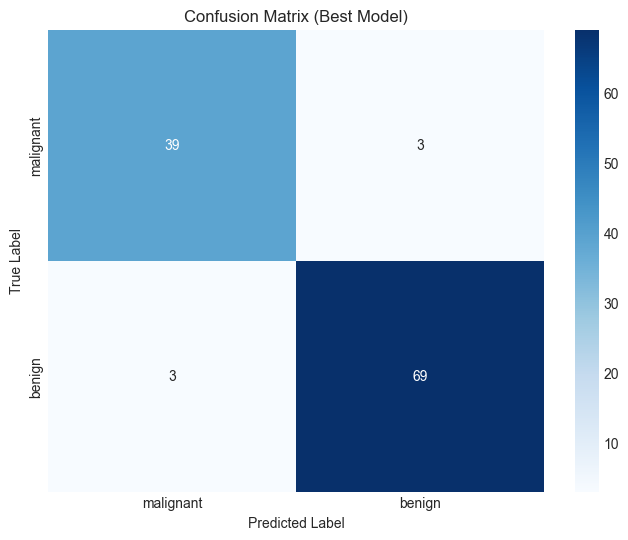

Classification Report (Best Model):
              precision    recall  f1-score   support

   malignant       0.93      0.93      0.93        42
      benign       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [19]:
# Confusion matrix for best model
best_cm_cls = confusion_matrix(y_test_cls, y_test_pred_best_cls)
plt.figure(figsize=(8, 6))
sns.heatmap(best_cm_cls, annot=True, fmt='d', cmap='Blues', 
            xticklabels=cancer.target_names, yticklabels=cancer.target_names)
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report for best model
print("Classification Report (Best Model):")
print(classification_report(y_test_cls, y_test_pred_best_cls, target_names=cancer.target_names))

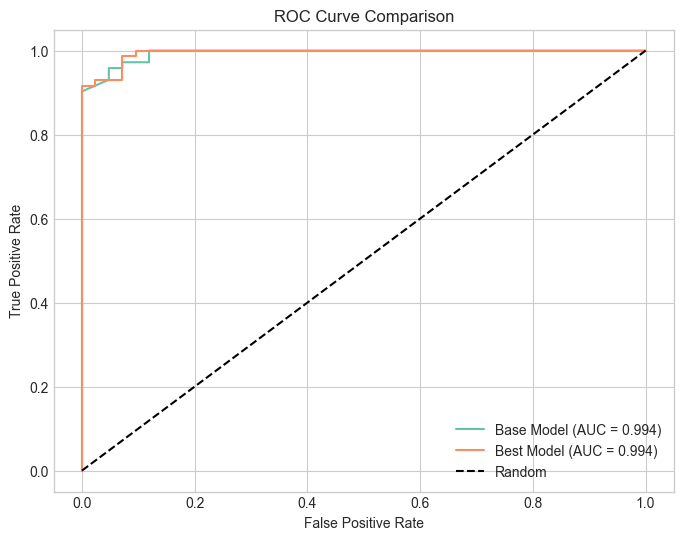

In [20]:
# Compare ROC curves of base and best models
fpr_best, tpr_best, thresholds_best = roc_curve(y_test_cls, y_test_proba_best_cls)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Base Model (AUC = {test_roc_auc_cls:.3f})')
plt.plot(fpr_best, tpr_best, label=f'Best Model (AUC = {best_test_roc_auc_cls:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

### 6. Cross-Validation and Learning Curves

In [21]:
# Perform 5-fold cross-validation
cv_scores_cls = cross_val_score(best_rf_cls, X_train_cls, y_train_cls, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cv_scores_cls}")
print(f"Mean CV score: {cv_scores_cls.mean():.4f}")
print(f"Standard deviation: {cv_scores_cls.std():.4f}")

Cross-validation scores: [0.97802198 1.         0.93406593 0.93406593 0.95604396]
Mean CV score: 0.9604
Standard deviation: 0.0256


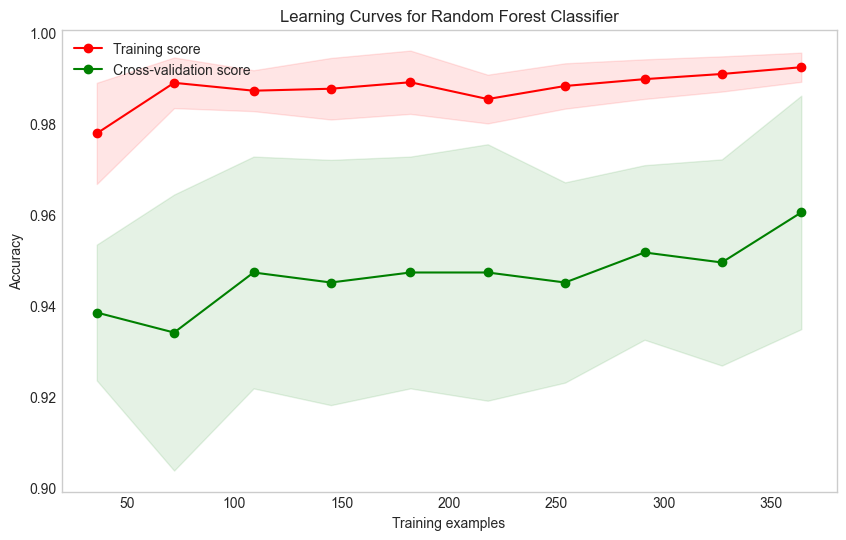

In [22]:
# Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_cls, X_train_cls, y_train_cls, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves for Random Forest Classifier")
plt.xlabel("Training examples")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

### 7. Out-of-Bag (OOB) Error Estimation

In [23]:
# Train a Random Forest with OOB score calculation
rf_oob = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_oob.fit(X_train_cls, y_train_cls)

# Get OOB score
oob_score = rf_oob.oob_score_
print(f"Out-of-Bag Score: {oob_score:.4f}")
print("This is an estimate of the model's accuracy on unseen data.")

Out-of-Bag Score: 0.9538
This is an estimate of the model's accuracy on unseen data.


### 8. Save the Classification Model

In [24]:
# Save the model
import os

if not os.path.exists('models'):
    os.makedirs('models')
    
joblib.dump(best_rf_cls, 'models/random_forest_classifier.pkl')
print("Classifier model saved to 'models/random_forest_classifier.pkl'")

Classifier model saved to 'models/random_forest_classifier.pkl'


## PART II: Random Forest Regression

### 1. Data Loading and Exploration - California Housing Dataset

In [25]:
# Load the California Housing dataset
housing = fetch_california_housing()
X_reg = pd.DataFrame(housing.data, columns=housing.feature_names)
y_reg = housing.target

# Display information about the dataset
print(f"Dataset shape: {X_reg.shape}")
print(f"Feature names: {housing.feature_names}")
print("Target: Median house value (in $100,000s)")

Dataset shape: (20640, 8)
Feature names: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Target: Median house value (in $100,000s)


In [26]:
# Create a DataFrame that includes the target variable
housing_df = X_reg.copy()
housing_df['MEDV'] = y_reg

# Display the first few rows of the dataset
housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MEDV
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [27]:
# Descriptive statistics
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MEDV
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


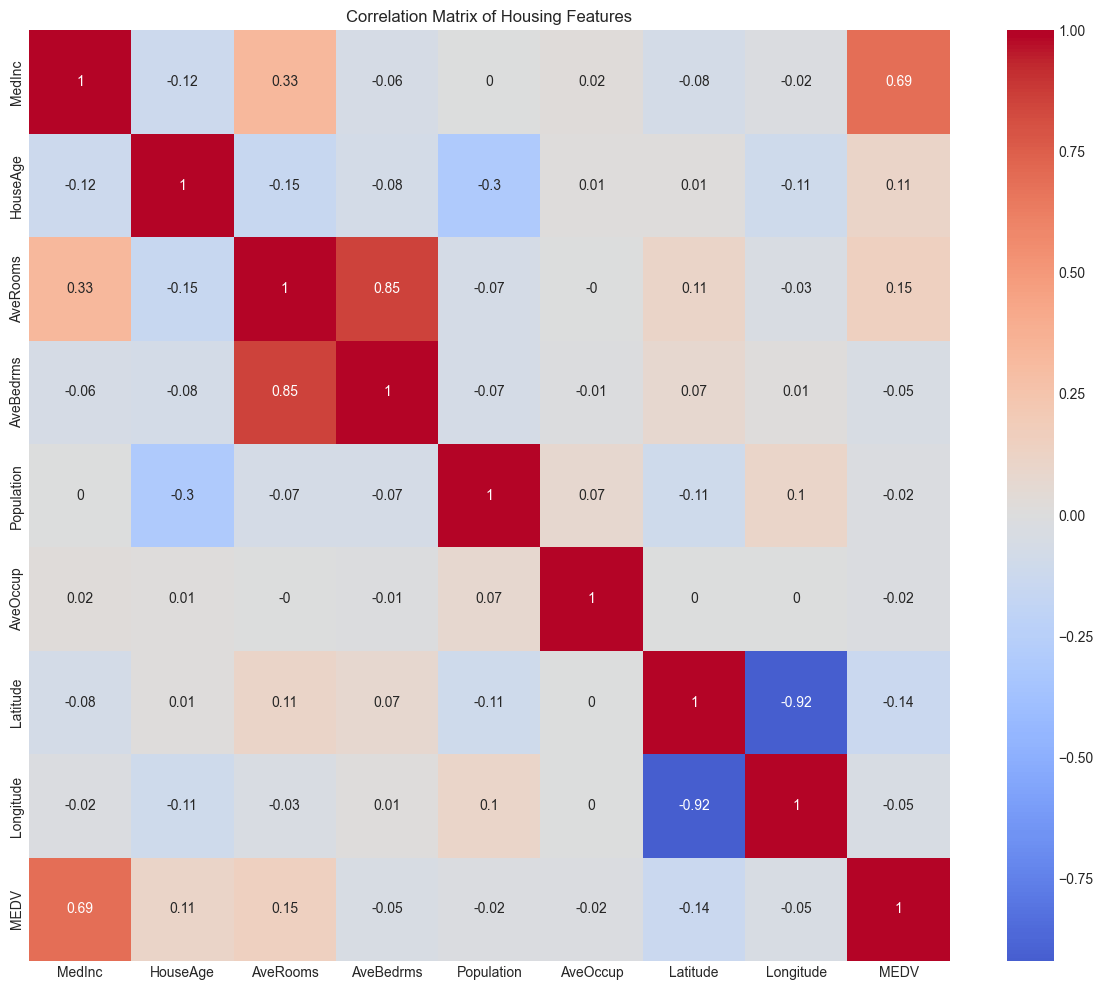

In [28]:
# Visualize correlations
plt.figure(figsize=(12, 10))
correlation_matrix = housing_df.corr().round(2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Housing Features')
plt.tight_layout()
plt.show()

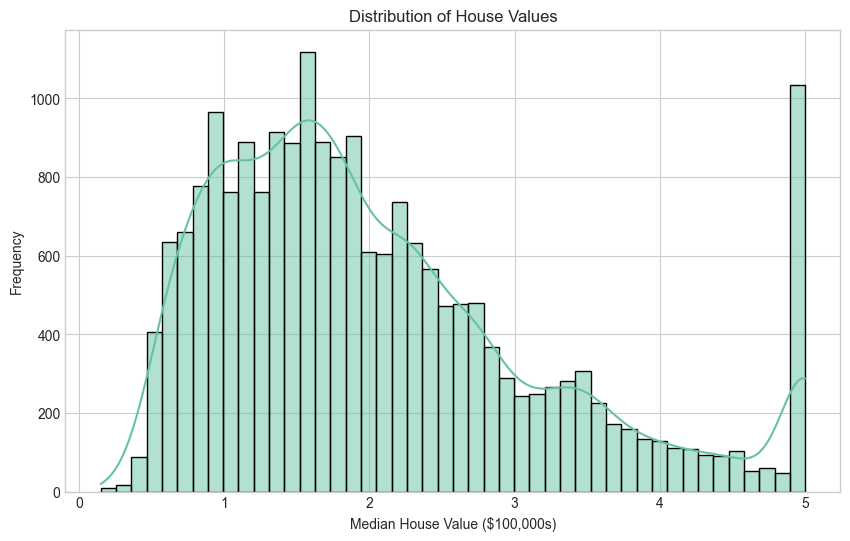

In [29]:
# Target distribution
plt.figure(figsize=(10, 6))
sns.histplot(housing_df['MEDV'], kde=True)
plt.title('Distribution of House Values')
plt.xlabel('Median House Value ($100,000s)')
plt.ylabel('Frequency')
plt.show()

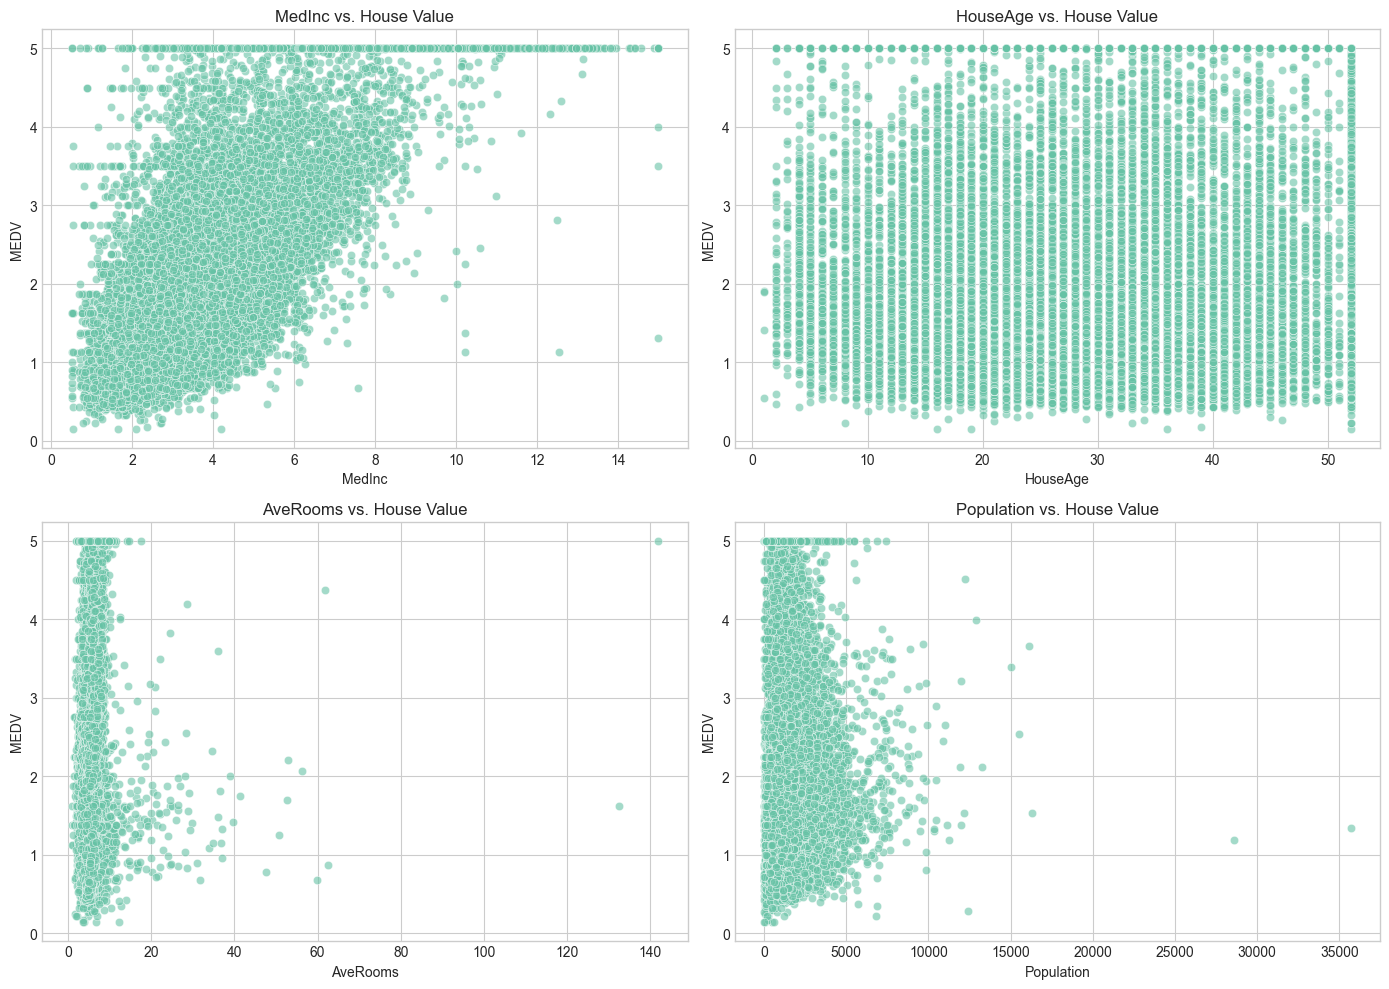

In [30]:
# Scatter plots for key features vs. target
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

important_features = ['MedInc', 'HouseAge', 'AveRooms', 'Population']
for i, feature in enumerate(important_features):
    sns.scatterplot(x=feature, y='MEDV', data=housing_df, alpha=0.6, ax=axes[i])
    axes[i].set_title(f'{feature} vs. House Value')
    
plt.tight_layout()
plt.show()

### 2. Data Preprocessing

In [31]:
# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train_reg.shape}")
print(f"Testing set shape: {X_test_reg.shape}")

Training set shape: (16512, 8)
Testing set shape: (4128, 8)


In [32]:
# Feature scaling
scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

# Convert back to DataFrames
X_train_reg_scaled_df = pd.DataFrame(X_train_reg_scaled, columns=X_reg.columns)
X_test_reg_scaled_df = pd.DataFrame(X_test_reg_scaled, columns=X_reg.columns)

print("First 5 rows of scaled training data:")
X_train_reg_scaled_df.head()

First 5 rows of scaled training data:


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,-0.326196,0.348490,-0.174916,-0.208365,0.768276,0.051376,-1.372811,1.272587
1,-0.035843,1.618118,-0.402835,-0.128530,-0.098901,-0.117362,-0.876696,0.709162
2,0.144701,-1.952710,0.088216,-0.257538,-0.449818,-0.032280,-0.460146,-0.447603
3,-1.017864,0.586545,-0.600015,-0.145156,-0.007434,0.077507,-1.382172,1.232698
4,-0.171488,1.142008,0.349007,0.086624,-0.485877,-0.068832,0.532084,-0.108551


### 3. Building a Basic Random Forest Regressor

In [33]:
# Initialize and train a basic random forest regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_train_reg)  # Use unscaled features for Random Forest

# Make predictions
y_train_pred_reg = rf_reg.predict(X_train_reg)
y_test_pred_reg = rf_reg.predict(X_test_reg)

# Evaluate the model
train_mse_reg = mean_squared_error(y_train_reg, y_train_pred_reg)
test_mse_reg = mean_squared_error(y_test_reg, y_test_pred_reg)
train_rmse_reg = np.sqrt(train_mse_reg)
test_rmse_reg = np.sqrt(test_mse_reg)
train_r2_reg = r2_score(y_train_reg, y_train_pred_reg)
test_r2_reg = r2_score(y_test_reg, y_test_pred_reg)

print(f"Training MSE: {train_mse_reg:.4f}")
print(f"Testing MSE: {test_mse_reg:.4f}")
print(f"Training RMSE: {train_rmse_reg:.4f}")
print(f"Testing RMSE: {test_rmse_reg:.4f}")
print(f"Training R²: {train_r2_reg:.4f}")
print(f"Testing R²: {test_r2_reg:.4f}")

Training MSE: 0.0353
Testing MSE: 0.2554
Training RMSE: 0.1880
Testing RMSE: 0.5053
Training R²: 0.9736
Testing R²: 0.8051


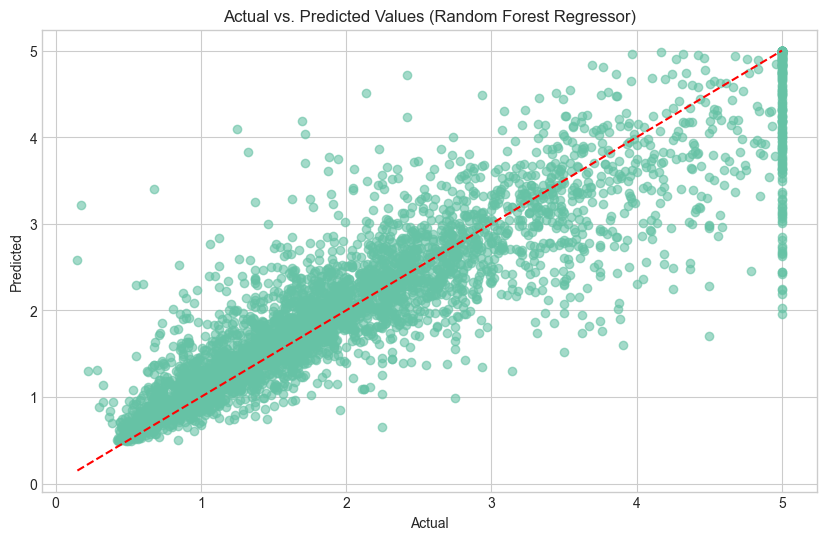

In [34]:
# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_test_pred_reg, alpha=0.6)
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Random Forest Regressor)')
plt.show()

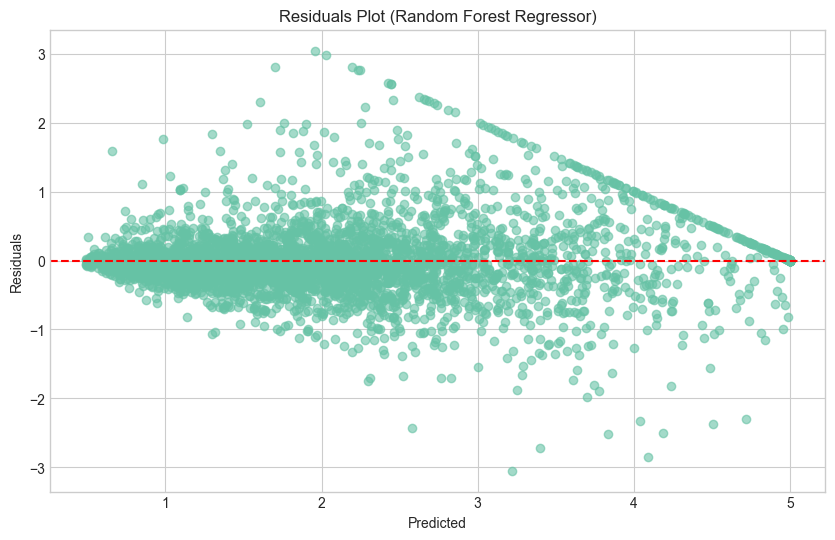

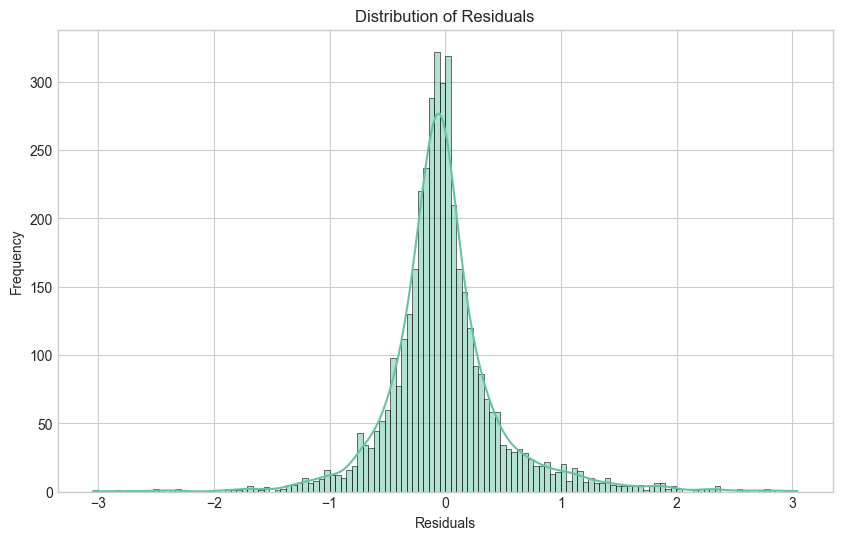

In [35]:
# Residuals Plot
residuals_reg = y_test_reg - y_test_pred_reg
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred_reg, residuals_reg, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals Plot (Random Forest Regressor)')
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals_reg, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

In [36]:
# Check for overfitting
print(f"Difference between training and testing R²: {train_r2_reg - test_r2_reg:.4f}")
if train_r2_reg - test_r2_reg > 0.1:
    print("The model may be overfitting.")
else:
    print("The model seems well-balanced.")

Difference between training and testing R²: 0.1684
The model may be overfitting.


### 4. Feature Importance for Regression

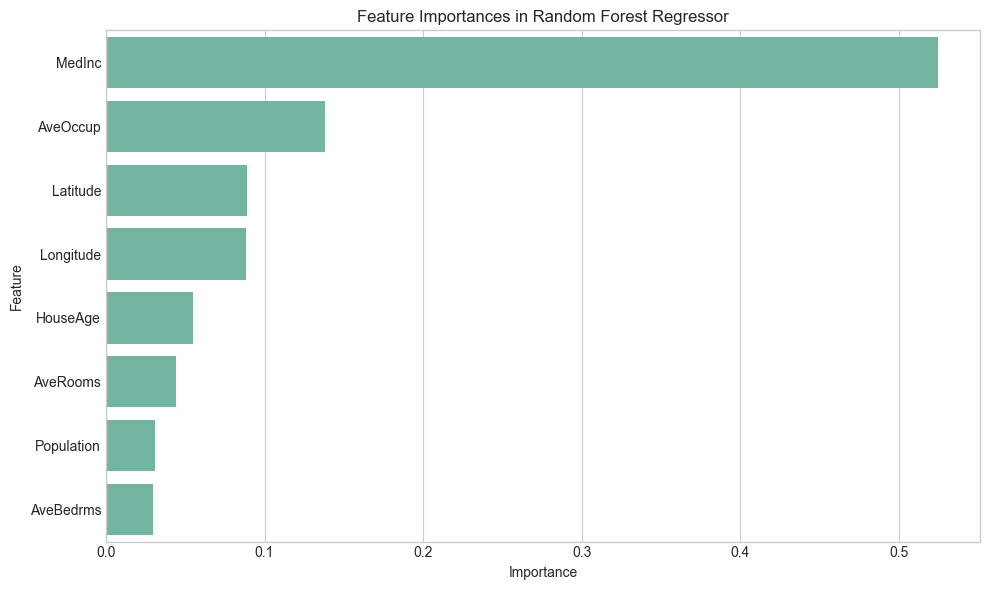

In [37]:
# Feature importance from the model
feature_importance_reg = pd.DataFrame({
    'Feature': X_reg.columns,
    'Importance': rf_reg.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_reg)
plt.title('Feature Importances in Random Forest Regressor')
plt.tight_layout()
plt.show()

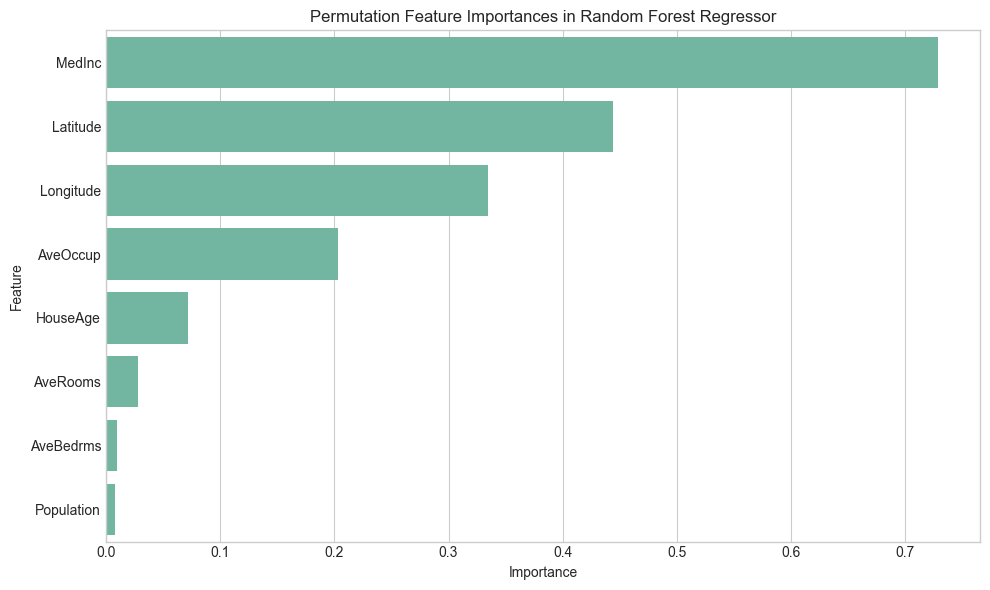

In [38]:
# Permutation importance
perm_importance_reg = permutation_importance(rf_reg, X_test_reg, y_test_reg, n_repeats=10, random_state=42)
perm_importance_reg_df = pd.DataFrame({
    'Feature': X_reg.columns,
    'Importance': perm_importance_reg.importances_mean
}).sort_values('Importance', ascending=False)

# Plot permutation importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=perm_importance_reg_df)
plt.title('Permutation Feature Importances in Random Forest Regressor')
plt.tight_layout()
plt.show()

### 5. Hyperparameter Tuning for Regression

In [39]:
# Define hyperparameters grid
# Using a reduced grid to save computation time
reduced_param_grid_reg = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt']
}

grid_search_reg = GridSearchCV(RandomForestRegressor(random_state=42), reduced_param_grid_reg, 
                           cv=5, scoring='neg_mean_squared_error')
grid_search_reg.fit(X_train_reg, y_train_reg)

# Best parameters and score
print(f"Best parameters: {grid_search_reg.best_params_}")
print(f"Best cross-validation MSE: {-grid_search_reg.best_score_:.4f}")

# Best model
best_rf_reg = grid_search_reg.best_estimator_

Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation MSE: 0.2501


In [40]:
# Evaluate the best model
y_train_pred_best_reg = best_rf_reg.predict(X_train_reg)
y_test_pred_best_reg = best_rf_reg.predict(X_test_reg)

best_train_mse_reg = mean_squared_error(y_train_reg, y_train_pred_best_reg)
best_test_mse_reg = mean_squared_error(y_test_reg, y_test_pred_best_reg)
best_train_rmse_reg = np.sqrt(best_train_mse_reg)
best_test_rmse_reg = np.sqrt(best_test_mse_reg)
best_train_r2_reg = r2_score(y_train_reg, y_train_pred_best_reg)
best_test_r2_reg = r2_score(y_test_reg, y_test_pred_best_reg)

print(f"Best Model Training MSE: {best_train_mse_reg:.4f}")
print(f"Best Model Testing MSE: {best_test_mse_reg:.4f}")
print(f"Best Model Training RMSE: {best_train_rmse_reg:.4f}")
print(f"Best Model Testing RMSE: {best_test_rmse_reg:.4f}")
print(f"Best Model Training R²: {best_train_r2_reg:.4f}")
print(f"Best Model Testing R²: {best_test_r2_reg:.4f}")

Best Model Training MSE: 0.0346
Best Model Testing MSE: 0.2493
Best Model Training RMSE: 0.1861
Best Model Testing RMSE: 0.4993
Best Model Training R²: 0.9741
Best Model Testing R²: 0.8098


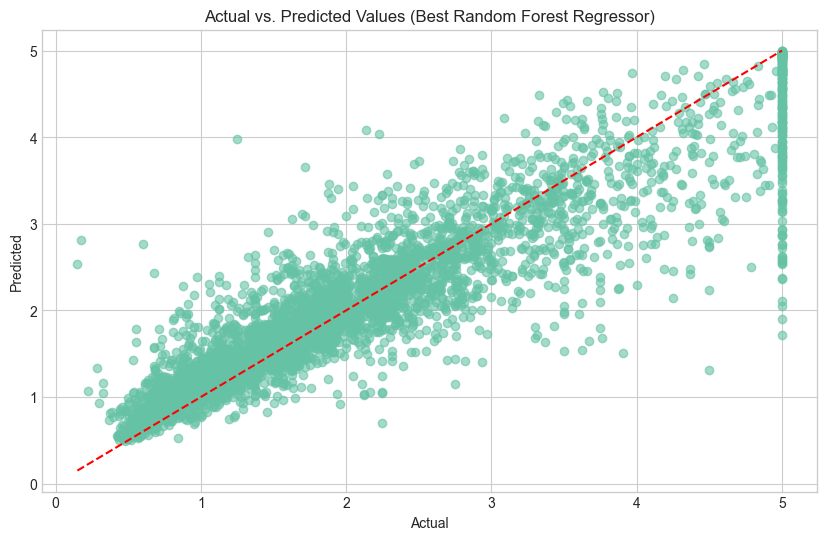

In [41]:
# Actual vs. Predicted Plot for Best Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_test_pred_best_reg, alpha=0.6)
plt.plot([y_reg.min(), y_reg.max()], [y_reg.min(), y_reg.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (Best Random Forest Regressor)')
plt.show()

### 6. Cross-Validation and Learning Curves for Regression

In [42]:
# Perform 5-fold cross-validation
cv_scores_reg = cross_val_score(best_rf_reg, X_train_reg, y_train_reg, cv=5, scoring='neg_mean_squared_error')
cv_mse_reg = -cv_scores_reg
cv_rmse_reg = np.sqrt(cv_mse_reg)
print(f"Cross-validation MSE scores: {cv_mse_reg}")
print(f"Cross-validation RMSE scores: {cv_rmse_reg}")
print(f"Mean CV MSE: {cv_mse_reg.mean():.4f}")
print(f"Mean CV RMSE: {cv_rmse_reg.mean():.4f}")
print(f"Standard deviation: {cv_mse_reg.std():.4f}")

Cross-validation MSE scores: [0.25235172 0.24911182 0.24765568 0.24532428 0.25586097]
Cross-validation RMSE scores: [0.50234622 0.49911103 0.49765016 0.49530221 0.50582702]
Mean CV MSE: 0.2501
Mean CV RMSE: 0.5000
Standard deviation: 0.0037


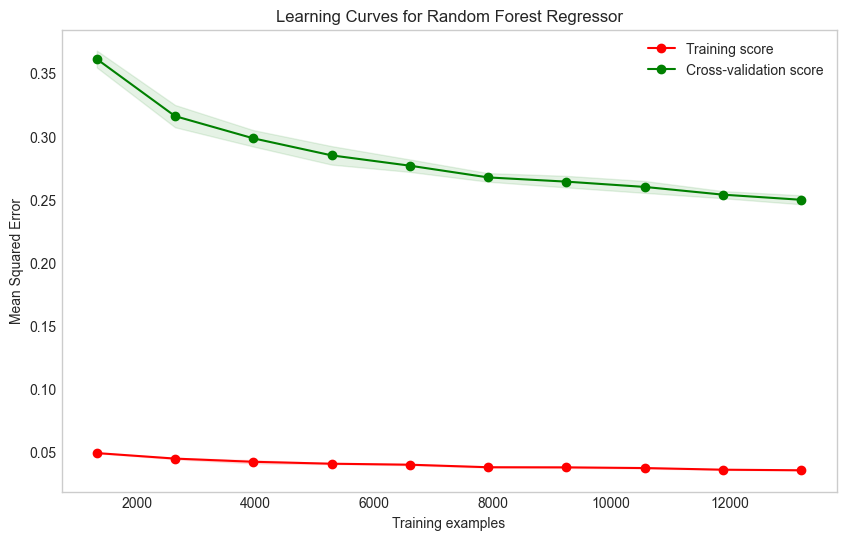

In [43]:
# Learning curve
train_sizes_reg, train_scores_reg, test_scores_reg = learning_curve(
    best_rf_reg, X_train_reg, y_train_reg, train_sizes=np.linspace(0.1, 1.0, 10), 
    cv=5, scoring='neg_mean_squared_error')

train_scores_mean_reg = -np.mean(train_scores_reg, axis=1)  # Negate to get positive MSE
train_scores_std_reg = np.std(train_scores_reg, axis=1)
test_scores_mean_reg = -np.mean(test_scores_reg, axis=1)  # Negate to get positive MSE
test_scores_std_reg = np.std(test_scores_reg, axis=1)

plt.figure(figsize=(10, 6))
plt.grid()
plt.fill_between(train_sizes_reg, train_scores_mean_reg - train_scores_std_reg,
                 train_scores_mean_reg + train_scores_std_reg, alpha=0.1, color="r")
plt.fill_between(train_sizes_reg, test_scores_mean_reg - test_scores_std_reg,
                 test_scores_mean_reg + test_scores_std_reg, alpha=0.1, color="g")
plt.plot(train_sizes_reg, train_scores_mean_reg, 'o-', color="r", label="Training score")
plt.plot(train_sizes_reg, test_scores_mean_reg, 'o-', color="g", label="Cross-validation score")
plt.title("Learning Curves for Random Forest Regressor")
plt.xlabel("Training examples")
plt.ylabel("Mean Squared Error")
plt.legend(loc="best")
plt.show()

### 7. Save the Regression Model

In [44]:
# Save the model
joblib.dump(best_rf_reg, 'models/random_forest_regressor.pkl')
print("Regressor model saved to 'models/random_forest_regressor.pkl'")

Regressor model saved to 'models/random_forest_regressor.pkl'


## 8. Comparing Random Forest with Decision Trees

In [45]:
# Load the decision tree models (make sure you've run the Decision Trees notebook first)
try:
    dt_cls_model = joblib.load('models/decision_tree_classifier.pkl')
    dt_reg_model = joblib.load('models/decision_tree_regressor.pkl')
    
    # Make predictions with the decision tree models
    dt_cls_pred = dt_cls_model.predict(X_test_cls)
    dt_reg_pred = dt_reg_model.predict(X_test_reg)
    
    # Calculate metrics
    dt_cls_accuracy = accuracy_score(y_test_cls, dt_cls_pred)
    dt_reg_mse = mean_squared_error(y_test_reg, dt_reg_pred)
    dt_reg_r2 = r2_score(y_test_reg, dt_reg_pred)
    
    # Compare with Random Forest
    print("Classification Performance Comparison:")
    print(f"Decision Tree Accuracy: {dt_cls_accuracy:.4f}")
    print(f"Random Forest Accuracy: {best_test_accuracy_cls:.4f}")
    print(f"Improvement: {best_test_accuracy_cls - dt_cls_accuracy:.4f}")
    
    print("\nRegression Performance Comparison:")
    print(f"Decision Tree MSE: {dt_reg_mse:.4f}")
    print(f"Random Forest MSE: {best_test_mse_reg:.4f}")
    print(f"Improvement: {dt_reg_mse - best_test_mse_reg:.4f}")
    
    print(f"Decision Tree R²: {dt_reg_r2:.4f}")
    print(f"Random Forest R²: {best_test_r2_reg:.4f}")
    print(f"Improvement: {best_test_r2_reg - dt_reg_r2:.4f}")
    
    # Bar plot comparison
    plt.figure(figsize=(12, 6))
    
    # Classification accuracy comparison
    plt.subplot(1, 2, 1)
    models = ['Decision Tree', 'Random Forest']
    accuracies = [dt_cls_accuracy, best_test_accuracy_cls]
    sns.barplot(x=models, y=accuracies)
    plt.title('Classification Accuracy Comparison')
    plt.ylim(0.9, 1.0)  # Adjusted to show differences better
    
    # Regression R² comparison
    plt.subplot(1, 2, 2)
    r2_scores = [dt_reg_r2, best_test_r2_reg]
    sns.barplot(x=models, y=r2_scores)
    plt.title('Regression R² Comparison')
    
    plt.tight_layout()
    plt.show()
    
except FileNotFoundError:
    print("Decision Tree models not found. Please run the Decision Trees notebook first.")

Decision Tree models not found. Please run the Decision Trees notebook first.


## Conclusion

In this notebook, we explored Random Forest for both classification and regression tasks:

### Random Forest Classification
- Used the Breast Cancer Wisconsin dataset to predict tumor malignancy.
- The base Random Forest model achieved high accuracy and ROC AUC scores.
- Hyperparameter tuning further improved model performance.
- Feature importance analysis revealed the most important predictors of tumor malignancy.
- Cross-validation and learning curves confirmed the model's robustness and generalization.

### Random Forest Regression
- Used the California Housing dataset to predict house prices.
- The model achieved good R² scores, indicating strong predictive power.
- Optimized the model through hyperparameter tuning.
- Identified key features that drive housing prices.
- Validated model performance using cross-validation.

### Key Advantages of Random Forest
1. **Higher Accuracy**: Random Forest generally outperforms single decision trees by combining multiple models.
2. **Reduced Overfitting**: Through bootstrap sampling and feature randomness, Random Forest mitigates overfitting.
3. **Feature Importance**: Provides robust feature importance measures, helping identify key predictors.
4. **Out-of-Bag Error Estimation**: Built-in validation mechanism without needing a separate validation set.
5. **Handles High-Dimensional Data**: Effectively manages datasets with many features.
6. **No Feature Scaling Required**: Like decision trees, Random Forest doesn't require feature normalization.

### Limitations
- Increased computational complexity compared to single decision trees.
- Less interpretable than single decision trees due to the ensemble nature.
- May struggle with highly imbalanced datasets without additional techniques.

### Best Practices
- Use a sufficient number of trees (`n_estimators`) to ensure convergence of the out-of-bag error.
- Consider `max_features` as a key hyperparameter for tuning.
- Use both built-in feature importance and permutation importance for robust feature analysis.
- Out-of-bag score provides a good estimate of model performance without a separate validation set.

Random Forest is a powerful algorithm for a wide range of machine learning tasks, offering a good balance between performance, robustness, and ease of use. Its ensemble nature helps overcome many limitations of single decision trees while maintaining many of their advantages.